<a href="https://colab.research.google.com/github/krishnamanc/PytorchPractice/blob/main/Cat_Dog_Classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 97% 212M/218M [00:01<00:00, 143MB/s]
100% 218M/218M [00:01<00:00, 130MB/s]


In [2]:
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [3]:
!pip install torchsummary

In [4]:
# Codeblock 1
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision

from tqdm import tqdm
from torchsummary import summary
from torch.utils.data import DataLoader

In [5]:
# Codeblock 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
# Codeblock 3
def load_images(path):

    images = []
    filenames = os.listdir(path)

    for filename in tqdm(filenames):
        if filename == '_DS_Store':
            continue
        image = cv2.imread(os.path.join(path, filename))
        image = cv2.resize(image, dsize=(224,224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)

    return np.array(images)

In [7]:
# Codeblock 4
cats_train = load_images('/content/training_set/training_set/cats')
dogs_train = load_images('/content/training_set/training_set/dogs')

cats_test = load_images('/content/test_set/test_set/cats')
dogs_test = load_images('/content/test_set/test_set/dogs')

100%|██████████| 1013/1013 [00:02<00:00, 445.55it/s]


In [8]:
# Codeblock 5
print(cats_train.shape)
print(dogs_train.shape)
print(cats_test.shape)
print(dogs_test.shape)

(4000, 224, 224, 3)
(4005, 224, 224, 3)
(1011, 224, 224, 3)
(1012, 224, 224, 3)


In [9]:
# Codeblock 6
X_train = np.append(cats_train, dogs_train, axis=0)
X_test  = np.append(cats_test, dogs_test, axis=0)

print(X_train.shape)
print(X_test.shape)

(8005, 224, 224, 3)
(2023, 224, 224, 3)


In [10]:
# Codeblock 7
y_train = np.array([0] * len(cats_train) + [1] * len(dogs_train))
y_test = np.array([0] * len(cats_test) + [1] * len(dogs_test))

print(y_train.shape)
print(y_test.shape)

(8005,)
(2023,)


In [11]:
# Codeblock 8
def show_images(images, labels, start_index):
    fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(20,12))

    counter = start_index

    for i in range(4):
        for j in range(8):
            axes[i,j].set_title(labels[counter].item())
            axes[i,j].imshow(images[counter], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

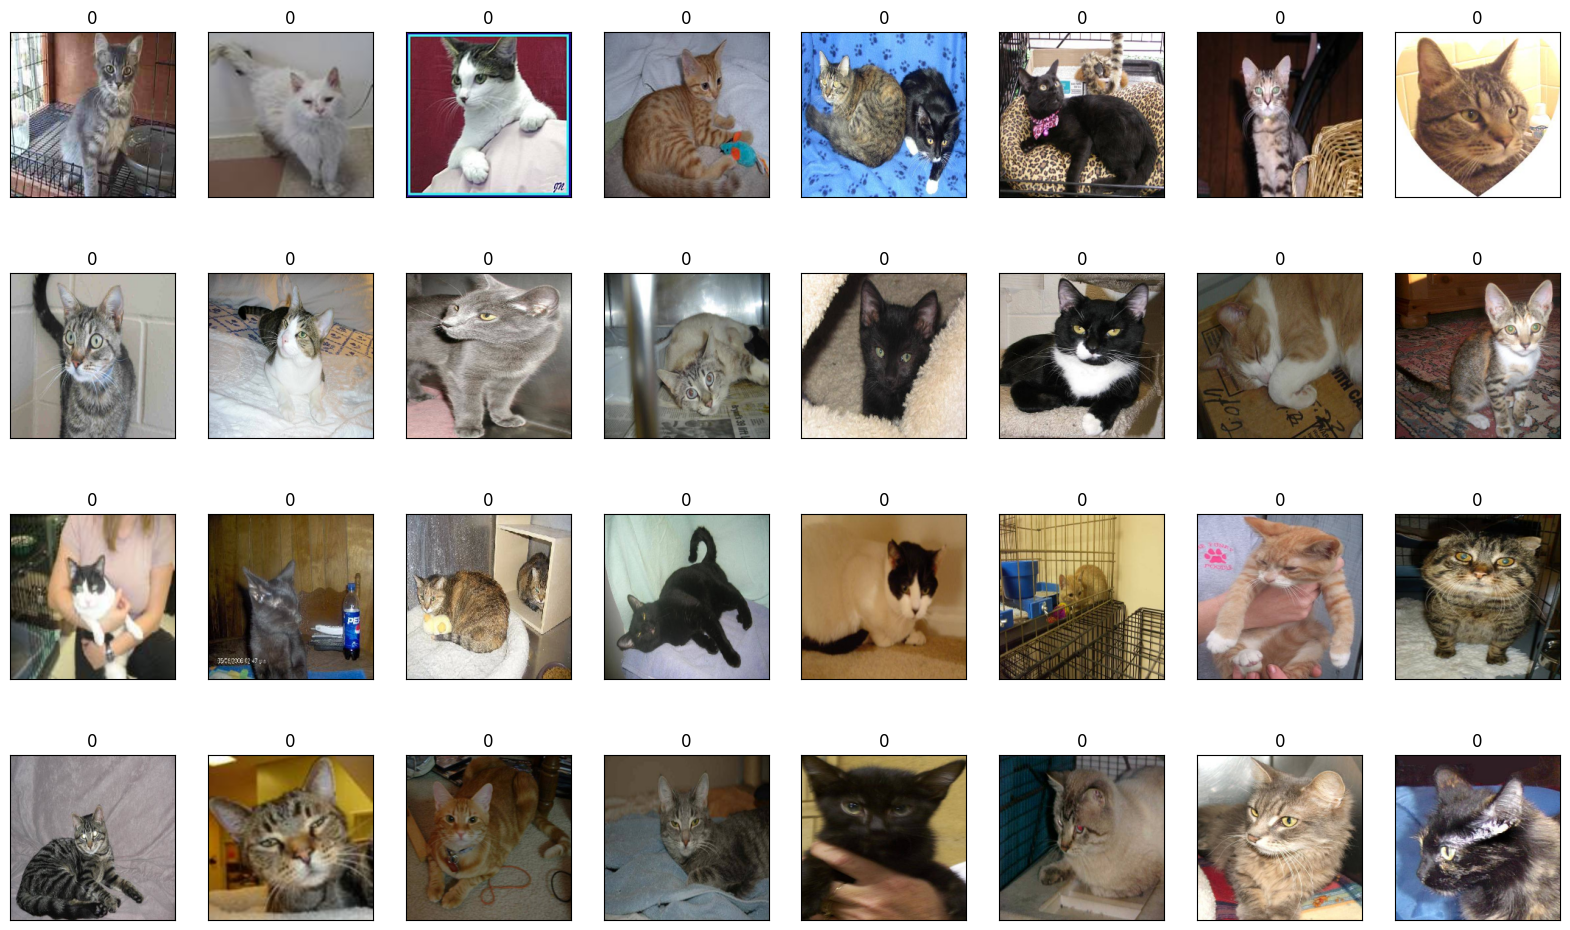

In [12]:
# Codeblock 9
show_images(X_train, y_train, 0)

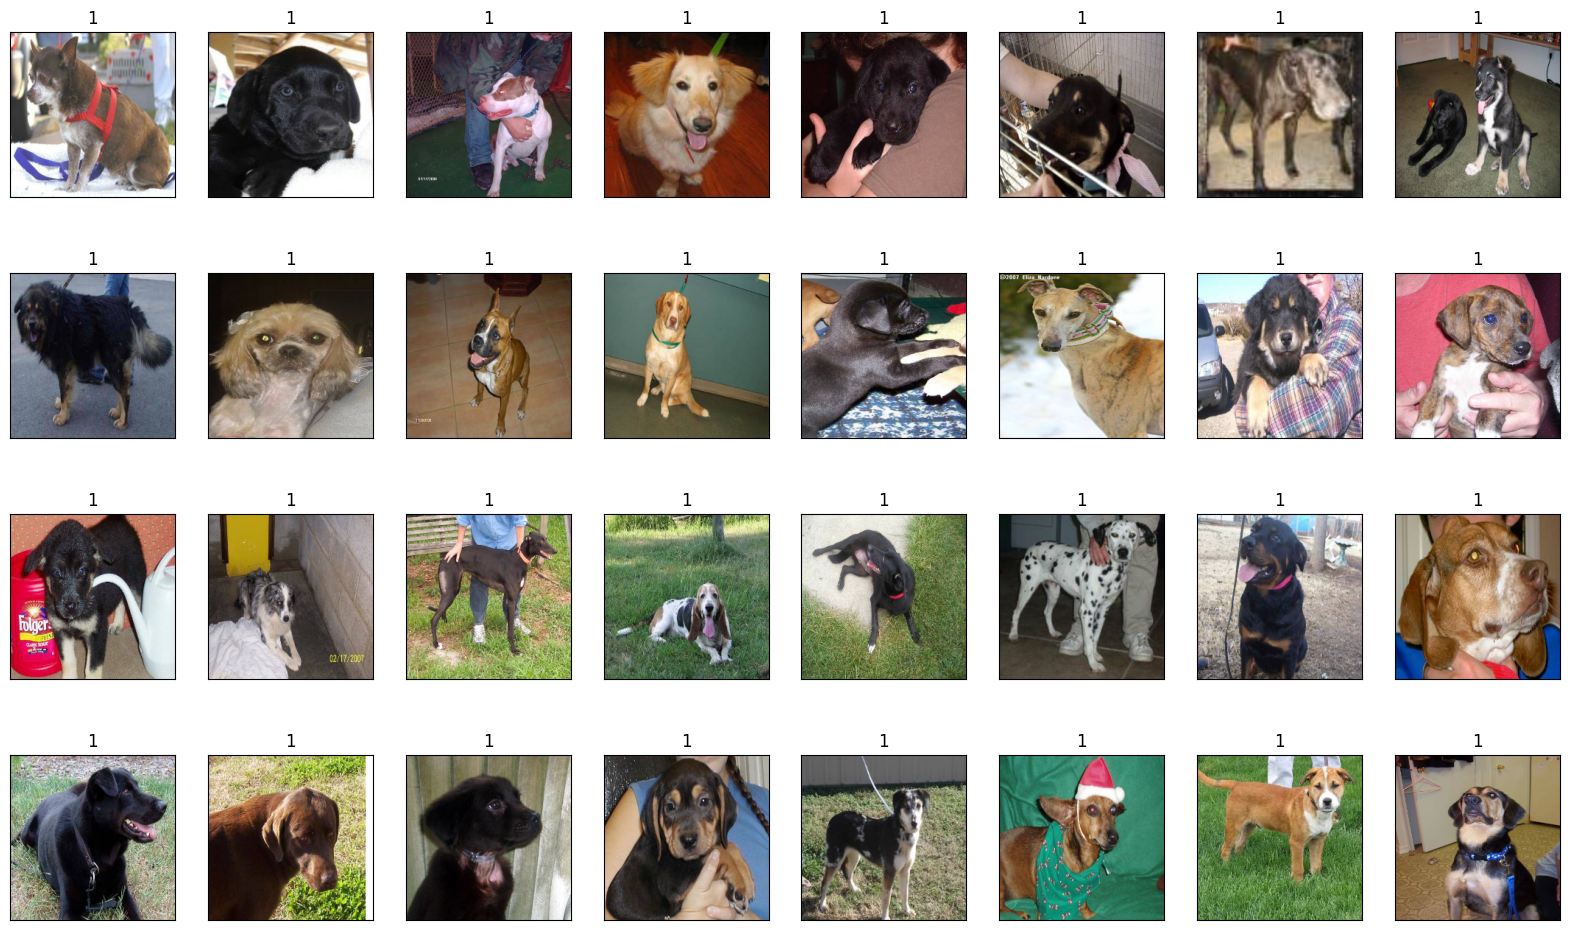

In [13]:
# Codeblock 10
show_images(X_train, y_train, 4000)

In [14]:
# Codeblock 11
print(y_train[:10])

[0 0 0 0 0 0 0 0 0 0]


In [15]:
# Codeblock 12
y_train = torch.from_numpy(y_train.reshape(len(y_train),1))
y_test = torch.from_numpy(y_test.reshape(len(y_test),1))

print(y_train[:10])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])


In [16]:
# Codeblock 13
transforms_train = transforms.Compose([transforms.ToTensor(), # convert to tensor
                                       transforms.RandomRotation(degrees=20),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.005),
                                       transforms.RandomGrayscale(p=0.2),
                                       transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # squeeze to -1 and 1
                                      ])

In [17]:
# Codeblock 14
transforms_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [18]:
# Codeblock 15
class Cat_Dog_Dataset():
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return (image, label)

In [19]:
# Codeblock 16
train_dataset = Cat_Dog_Dataset(images=X_train, labels=y_train, transform=transforms_train)
test_dataset  = Cat_Dog_Dataset(images=X_test, labels=y_test, transform=transforms_test)

In [20]:
# Codeblock 17
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=True, drop_last=True)

In [21]:
# Codeblock 18
iterator = iter(train_loader)
image_batch, label_batch = next(iterator)

print(image_batch.shape)

torch.Size([32, 3, 224, 224])


torch.Size([32, 224, 224, 3])


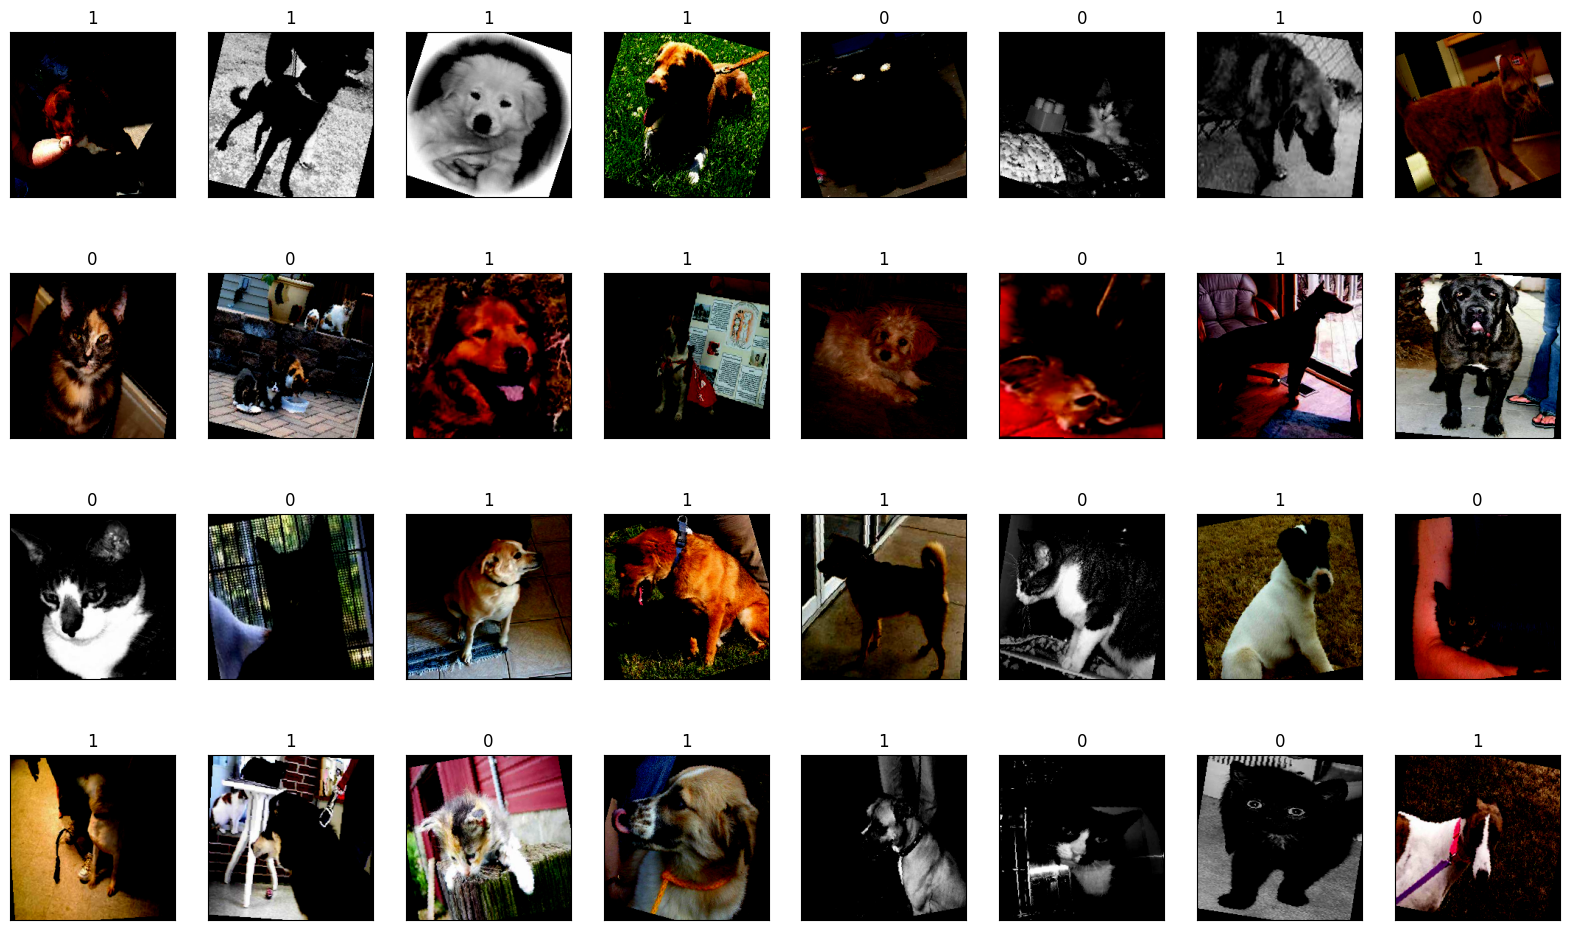

In [22]:
# Codeblock 19
image_batch_permuted = image_batch.permute(0, 2, 3, 1)

print(image_batch_permuted.shape)

show_images(image_batch_permuted, label_batch, 0)

In [23]:
model = torchvision.models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.DEFAULT')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 89.4MB/s]


In [24]:
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [25]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

In [26]:
for param in model.parameters():
    param.requires_grad = False

In [27]:
model.classifier[3].out_features

1000

In [28]:
# Replace the final classification layer with a new linear layer with 2 output features
model.classifier[3] = nn.Sequential(
    nn.Linear(in_features=model.classifier[3].in_features, out_features=128),
    nn.ReLU(inplace=True),
    nn.Linear(128,64),
    nn.ReLU(inplace=True),
    nn.Linear(64,32),
    nn.ReLU(inplace=True),
    nn.Linear(32,16),
    nn.ReLU(inplace=True),
    nn.Linear(16,1),
    nn.Sigmoid()
    )

In [29]:
model.to(device)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [30]:
# Codeblock 22
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
              ReLU-6         [-1, 16, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             256
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 64, 112, 112]           1,024
      BatchNorm2d-11         [-1, 64, 112, 112]             128
             ReLU-12         [-1, 64, 112, 112]               0
           Conv2d-13           [-1, 64, 56, 56]             576
      BatchNorm2d-14           [-1, 64,

In [31]:
# Codeblock 23
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
def predict_test_data(model, test_loader):

    num_correct = 0
    num_samples = 0

    model.eval()

    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test = X_test.float().to(device)
            y_test = y_test.float().to(device)

            # Calculate loss (forward propagation)
            test_preds = model(X_test)
            test_loss  = loss_function(test_preds, y_test)

            # Calculate accuracy
            rounded_test_preds = torch.round(test_preds)
            num_correct += torch.sum(rounded_test_preds == y_test)
            num_samples += len(y_test)

    model.train()

    test_acc = num_correct/num_samples

    test_acc = torch.round(test_acc * 100) / 100

    return test_loss, test_acc

In [33]:
X_train.shape

(8005, 224, 224, 3)

In [ ]:
for epoch in range(10):
    num_correct_train = 0
    num_samples_train = 0
    for batch, (X_train, y_train) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X_train = X_train.float().to(device)
        y_train = y_train.float().to(device)  # Ensure y_train is of the correct dtype

        # Forward propagation
        train_preds = model(X_train)
        train_loss = loss_function(train_preds, y_train)

        # Calculate train accuracy
        with torch.no_grad():
            _, predicted = torch.max(train_preds, 1)
            num_correct_train += (predicted == y_train).sum().item()
            num_samples_train += y_train.size(0)

        # Backward propagation
        optimizer.zero_grad()
        train_loss.backward()

        # Gradient descent
        optimizer.step()

    train_acc = num_correct_train / num_samples_train

    print(f'Epoch: {epoch} \t|'
          f' Train loss: {np.round(train_loss.item(), 3)} \t|'
          f' Train acc: {np.round(train_acc, 2)} \t|')

100%|██████████| 250/250 [00:38<00:00,  6.46it/s]


Epoch: 0 	| Train loss: 0.033 	| Train acc: 15.99 	|


100%|██████████| 250/250 [00:40<00:00,  6.24it/s]


Epoch: 1 	| Train loss: 0.055 	| Train acc: 15.98 	|


100%|██████████| 250/250 [00:38<00:00,  6.42it/s]


Epoch: 2 	| Train loss: 0.005 	| Train acc: 15.99 	|


100%|██████████| 250/250 [00:38<00:00,  6.52it/s]


Epoch: 3 	| Train loss: 0.146 	| Train acc: 15.99 	|


 74%|███████▍  | 186/250 [00:28<00:09,  6.73it/s]

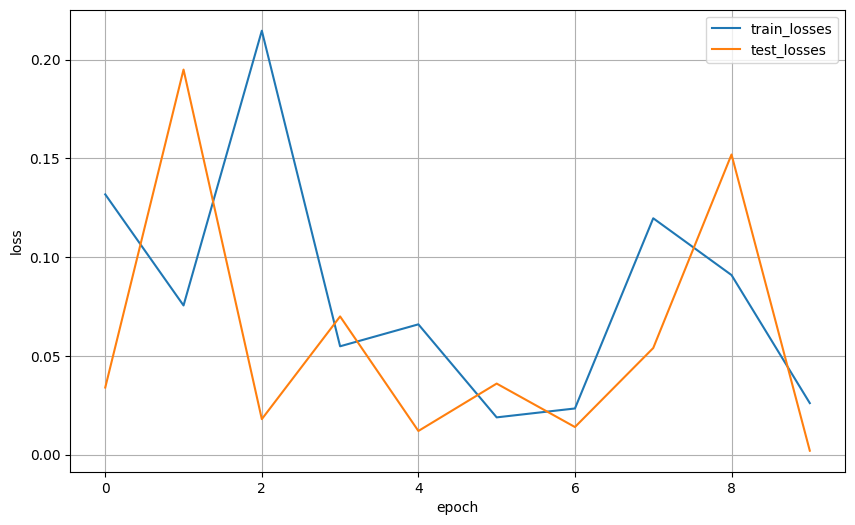

In [45]:
# Codeblock 26
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train_losses', 'test_losses'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [46]:
torch.save(model, 'catdog1.pth')

In [48]:
# Codeblock 27
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(train_accs)
plt.plot(test_accs)
plt.legend(['train_accs', 'test_accs'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [47]:
# Codeblock 28

# Load test images
iter_test = iter(test_loader)
img_test, lbl_test = next(iter_test)

# Predict labels
preds_test = model(img_test.to(device))
img_test_permuted = img_test.permute(0, 2, 3, 1)
rounded_preds = preds_test.round()

# Show test images and the predicted labels
show_images(img_test_permuted, rounded_preds, 0)